This is a notebook with a super rough implementation of a Fashion MNIST classification task.

The task is slightly complicated by:<br>
- removing all "bags"<br>
- consolidating all types of shoes into a single category.

(The naming of variables gets a little wild. If this were to be refactored, I would functionalize the preprocessing operations.)

More information about this dataset can be found: https://keras.io/api/datasets/fashion_mnist/

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [ ]:
# load some fashion data

(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.fashion_mnist.load_data()

train_images.shape

(60000, 28, 28)

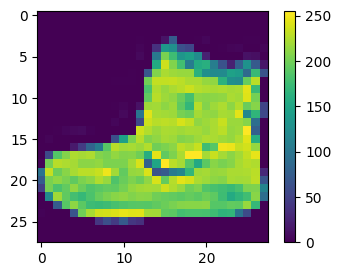

In [ ]:
''' quick visualize '''
plt.figure(figsize=(4,3))
plt.imshow(train_images[0])
plt.colorbar()

# these data go up to 255 !

In [ ]:
''' convert labels into a one-hot-encoding '''
# need to turn these labels into different classes
from sklearn.preprocessing import OneHotEncoder
my_ohe = OneHotEncoder()
ohed_labels = my_ohe.fit_transform(train_labels.reshape(-1,1)).todense()
ohed_labels.shape

(60000, 10)

Text(0, 0.5, 'sample index')

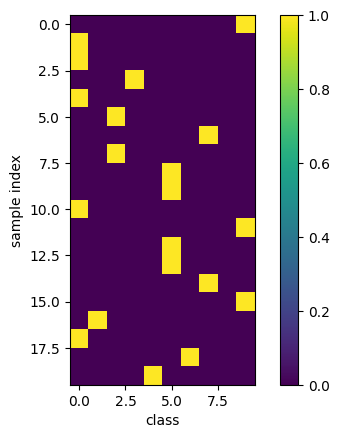

In [ ]:
''' visualize the one-hot-encoding'''
plt.imshow(ohed_labels[:20])
plt.colorbar()
plt.xlabel('class')
plt.ylabel('sample index')

This next section consolidates the shoe types together. The link above provides information about which columns are what fashion item.

The way I'm going about this is to create a new column that is "True" for each sample that is a shoe type and "False" for everything else.

This column will be appended to the labels, then I'll remove the shoe columns.

In [ ]:
# how to consolidate shoes together?

# make new column that is OR'ed together? then drop those three? seems like the most straight forward

shoe_columns = [5,7,9]

# make a 60k feature column that is "true" if the sample is shoe

sandal_column = ohed_labels[:, 5].astype(bool) # boolean allows bitwise operations
sneaker_column = ohed_labels[:, 7].astype(bool)
boot_column = ohed_labels[:, 9].astype(bool)

generic_shoe = sandal_column | sneaker_column | boot_column # bitwise OR on each column
generic_shoe[:10] # take first 10 samples to see if it makes ANY sense

matrix([[ True],
        [False],
        [False],
        [False],
        [False],
        [False],
        [ True],
        [False],
        [ True],
        [ True]])

(60000, 11)

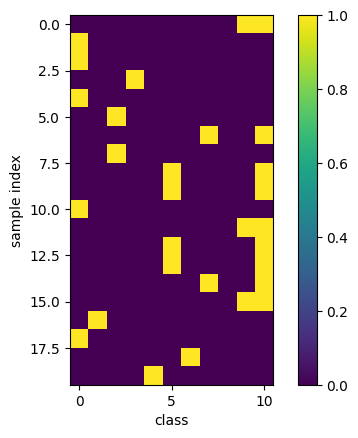

In [ ]:
# attach this column to the ohe_features

# quick sanity check
plt.imshow(np.concatenate([ohed_labels, generic_shoe],axis=1)[:20])
plt.colorbar()
plt.xlabel('class')
plt.ylabel('sample index')

# columns 5,7, and 9 are active on the last column (our generic_shoe). so it passes the sanity check

ohed_generic_shoe = np.concatenate([ohed_labels, generic_shoe],axis=1)
ohed_generic_shoe.shape

In [ ]:
# now drop those specific shoe columns

# (these variable naming conventions are really poor. these are only going to get longer when the "bags" are removed)
ohed_generic_shoe_reduced = ohed_generic_shoe[:,[0,1,2,3,4,6,8,10]] # this selects all samples and specific columns
ohed_generic_shoe_reduced.shape

(60000, 8)

This next section removes the "bag" samples. These samples can be identified using the "bag" labels. Due to us shifting around the columns by consolidating the shoes, the new "bag" column is the second from the end [:, -2].

I'm creating a temporary "mask" that is a boolean array using the sample labels, and I can use that to remove the "bag" samples

In [ ]:
# lol, now to drop bags

# the bag column shifted with the above operation; it's not the second to last column
# identify "bag" samples
mask = (ohed_generic_shoe_reduced[:,-2] == 1) # if the second last column is active, add it to the mask
print(mask.sum()) # summing a boolean is the same as counting
print(mask.shape)
mask = mask[:,0] # drop the dumby dimension
print(mask.shape) # what?

# it's apparently a np.matrix. convert this into an array (what the hell is a numpy matrix?)
mask = np.array(mask).squeeze()
print(mask.shape)

6000
(60000, 1)
(60000, 1)
(60000,)


(array([   23,    35,    57, ..., 59962, 59967, 59994]), array([0, 0, 0, ..., 0, 0, 0]))


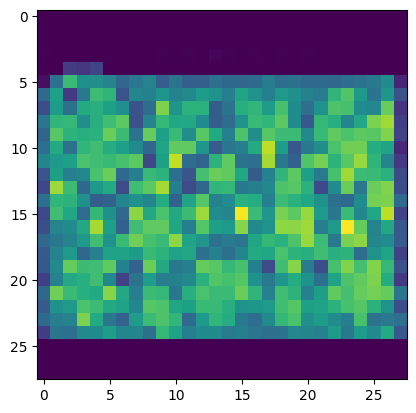

In [ ]:
# check i'm dropping the correct column
print(np.where(mask == True)) # these are the indices that are "bags"

plt.imshow(train_images[23]) # i guess that's a bag


In [ ]:
# fix labels
ohed_generic_shoe_reduced_bag_removed = ohed_generic_shoe_reduced[mask]
# fix images
train_images_bag_removed = train_images[mask]

print(ohed_generic_shoe_reduced_bag_removed.shape)
print(train_images_bag_removed.shape)

# oops, that's backwards (and an example of why using .shape is useful)

(6000, 8)
(6000, 28, 28)


In [ ]:
mask = np.array((ohed_generic_shoe_reduced[:,-2] != 1)).squeeze() # if the second last column is NOT active, add it to the mask
print(mask.shape)

# fix labels
ohed_generic_shoe_reduced_bag_removed = ohed_generic_shoe_reduced[mask]
# fix images
train_images_bag_removed = train_images[mask]

print(ohed_generic_shoe_reduced_bag_removed.shape)
print(train_images_bag_removed.shape)

(60000,)
(54000, 8)
(54000, 28, 28)


Preprocessing is done. Bags are dropped and shoes are consolidated. Preprocessing of testing set can be done later.

Next we define a model. It will have an input of (28,28,1) for height, width, number of channels. And an output of 8, for each of the 8 potential classes. <br><br>

... Just realized - we got rid of the "bag" samples, but not the "bag" column. So, there's a column that will never be active. It won't hurt, but it can be removed if this ever gets refactored.

In [ ]:
def build_model():
  xin = tf.keras.layers.Input((28,28,1))
  x0 = tf.keras.layers.Conv2D(16, (3,3),activation='relu')(xin)
  x0 = tf.keras.layers.Conv2D(16, (3,3),activation='relu')(x0)
  x0 = tf.keras.layers.MaxPooling2D()(x0)
  x0 = tf.keras.layers.Conv2D(16, (3,3),activation='relu')(x0)
  x0 = tf.keras.layers.Conv2D(16, (3,3),activation='relu')(x0)
  x0 = tf.keras.layers.MaxPooling2D()(x0)
  x0 = tf.keras.layers.Flatten()(x0)     # < forgot this the first time around.
  x0 = tf.keras.layers.Dense(64, activation='relu')(x0)
  xout = tf.keras.layers.Dense(8,activation='softmax')(x0)
  return tf.keras.models.Model(xin,xout)

build_model().summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 26, 26, 16)        160       
                                                                 
 conv2d_7 (Conv2D)           (None, 24, 24, 16)        2320      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 12, 12, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 10, 10, 16)        2320      
                                                                 
 conv2d_9 (Conv2D)           (None, 8, 8, 16)          2320      
                                                           

Epoch 1/10
380/380 [==============================] - 65s 166ms/step - loss: 0.1587 - val_loss: 0.1003
Epoch 2/10
380/380 [==============================] - 73s 192ms/step - loss: 0.0937 - val_loss: 0.0908
Epoch 3/10
380/380 [==============================] - 96s 252ms/step - loss: 0.0827 - val_loss: 0.0821
Epoch 4/10
380/380 [==============================] - 43s 114ms/step - loss: 0.0764 - val_loss: 0.0749
Epoch 5/10
380/380 [==============================] - 42s 110ms/step - loss: 0.0720 - val_loss: 0.0734
Epoch 6/10
380/380 [==============================] - 41s 109ms/step - loss: 0.0682 - val_loss: 0.0702
Epoch 7/10
380/380 [==============================] - 43s 114ms/step - loss: 0.0647 - val_loss: 0.0659
Epoch 8/10
380/380 [==============================] - 59s 155ms/step - loss: 0.0615 - val_loss: 0.0651
Epoch 9/10
380/380 [==============================] - 58s 152ms/step - loss: 0.0592 - val_loss: 0.0641
Epoch 10/10
380/380 [==============================] - 48s 127ms/step - l

Text(0, 0.5, 'loss')

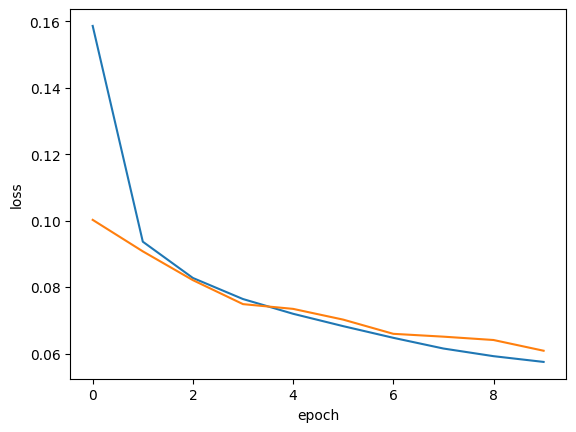

In [ ]:
# define model
my_model = build_model()

# compile
my_model.compile(loss='binary_crossentropy',
                 optimizer='adam')
# >>>>>>>>>>>>>  metrics=['acc']) <<<<<<<<<<<< strongly suggest including the accuracy metric.

hist = my_model.fit(train_images_bag_removed/255, # scale the input images
                    ohed_generic_shoe_reduced_bag_removed,
                    batch_size=128,
                    verbose=1,
                    epochs=10,
                    validation_split = 0.1 # 10% of samples used for validation
                    )

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')

I wasn't training on GPU, so this went slowly.

During that time I wrote (below) the preprocessing steps for the testing data. It follows the same process as above, but with different variable names. (Again, this should be refactored into a function for clarity and to minimize extra copies of the data).

In [ ]:
''' not on GPU ! '''
# while (slowly) training, fix the test set

ohed_labels_test = my_ohe.fit_transform(test_labels.reshape(-1,1)).todense()



sandal_column = ohed_labels_test[:, 5].astype(bool) # boolean allows bitwise operations
sneaker_column = ohed_labels_test[:, 7].astype(bool)
boot_column = ohed_labels_test[:, 9].astype(bool)

generic_shoe = sandal_column | sneaker_column | boot_column # bitwise OR on each column
generic_shoe[:10] # take first 10 samples to see if it makes ANY sense



ohed_generic_shoe_test = np.concatenate([ohed_labels_test, generic_shoe],axis=1)
ohed_generic_shoe_reduced_test = ohed_generic_shoe_test[:,[0,1,2,3,4,6,8,10]] # drop original shoe-like columns



mask = np.array((ohed_generic_shoe_reduced_test[:,-2] != 1)).squeeze() # if the second last column is active, add it to the mask

# fix labels
ohed_generic_shoe_reduced_bag_removed_test = ohed_generic_shoe_reduced_test[mask]
# fix images
test_images_bag_removed_test = test_images[mask]


In [ ]:
my_model.evaluate(test_images_bag_removed_test/255,
                  ohed_generic_shoe_reduced_bag_removed_test
                  )

# forgot to add 'acc' as a metric. well. it's at least a low loss value

282/282 [==============================] - 5s 16ms/step - loss: 0.0622


0.06221672147512436

Evaluate the model: using the test set, make predictions. Compare those predictions to the target values.

In [ ]:
pred = my_model.predict(test_images_bag_removed_test/255)

282/282 [==============================] - 5s 17ms/step


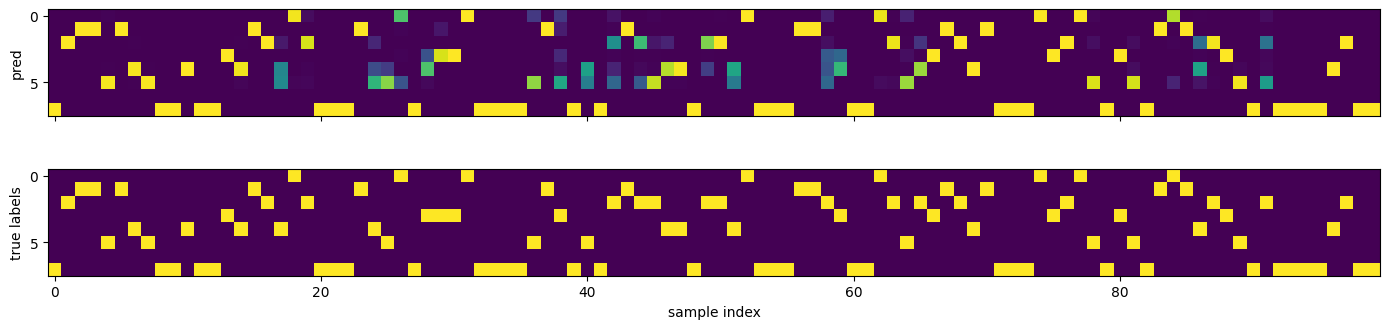

In [ ]:
# The top image are the predictions
# The bottom image are the target values.

fig,ax=plt.subplots(2,1,figsize=(14,4),sharex=True)
ax[0].imshow(pred[:100].T)
ax[0].set_ylabel('pred')

ax[1].imshow(ohed_generic_shoe_reduced_bag_removed_test[:100].T)
ax[1].set_ylabel('true labels')
ax[1].set_xlabel('sample index')
plt.tight_layout()

In [ ]:
# seems reasonable. not amazing, but reasonable

To justify the shoe consolidation and bag removal, these are both pretty common processes in data cleaning. For shoe consolidation, that is feature engineering - create a new feature based on data that is already available after simple manipulations. Bag removal is essentially the same as outlier removal - select samples that match some criterion, and remove them from the dataset.
